# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

## Preliminary Visual Inspection
Becoming familiar with the data:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

print('>>> Shape =', df.shape)
display(df.head(5))    
print('\n>>> Columns [', len(df.columns), ']\n', df.columns)
#print('\n>>> Types\n', df.dtypes)

>>> Shape = (4870, 65)


,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit



>>> Columns [ 65 ]
 Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')


In [2]:
# number of callbacks for white-sounding names
w_df       = df[df.race == 'w'] 
w_call_sum = np.sum(w_df.call)
w_percent  = w_call_sum / w_df.shape[0] * 100

# number of callbacks for black-sounding names
b_df       = df[df.race == 'b']
b_call_sum = np.sum(b_df.call)
b_percent  = b_call_sum / b_df.shape[0] * 100

print('>>> w_call_sum =', w_call_sum, 'w_percent=', round(w_percent, 2), '%')
print('>>> b_call_sum =', b_call_sum, 'b_percent=', round(b_percent, 2), '%')

>>> w_call_sum = 235.0 w_percent= 9.65 %
>>> b_call_sum = 157.0 b_percent= 6.45 %


In [3]:
# Plot yearsexp vs race
def plot_yearsexp_vs_call(df, title):
    series = df.groupby(['yearsexp']).aggregate(np.sum).call
    
    ax = series.plot(title=title, kind='bar', ylim=(0, 35))
    ax.set_xlabel('Years of Experience')
    ax.set_ylabel('Number of Callbacks')  
    
    # fix 90 degree rotation caused by standard parameters
    loc, labels = plt.xticks()
    ax.set_xticklabels(labels, rotation=0)

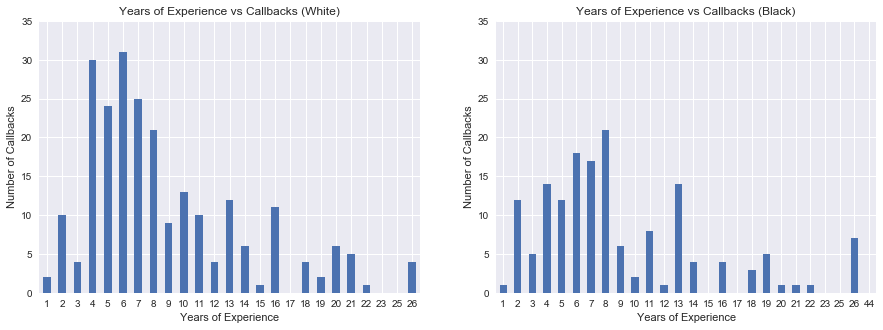

In [4]:
sns.set()
fig, ax = plt.subplots(figsize=(15,5))

plt.subplot(1, 2, 1)
plot_yearsexp_vs_call(w_df, 'Years of Experience vs Callbacks (White)')

plt.subplot(1, 2, 2)
plot_yearsexp_vs_call(b_df, 'Years of Experience vs Callbacks (Black)')

plt.show()

---
## 1. What test is appropriate for this problem? Does CLT apply?

**Yes**, CLT does apply. An appropriate test for this problem is to determine if the [difference between two proportions](http://stattrek.com/hypothesis-test/difference-in-proportions.aspx) is significant. For this goal, a **two-proportion z-test** can be used. 

According to the **Central Limit Theorem** (CLT), the following conditions must be met:
* **The samples must be independent**! They are, the races were randomly assigned to identical résumés. One observation does not provide any information about the other.
* **10% Rule** - the sample size must not be bigger than 10% of the entire population! They are, the sample sizes are 9.65% and 6.45%.
* **The sample size must be "big enough"** (`n >= 30`)! It is, there are 2435 samples for each race.

This is what we know about the data:
- From all 2435 resumes with white-sounding names, 9.65% received a call.
- From all 2435 resumes with black-sounding names, 6.45% received a call.

In [5]:
print('>>> Callbacks for W-names =', w_call_sum, '/', w_df.shape[0], '(', round(w_percent, 2), '%)')
print('>>> Callbacks for B-names =', b_call_sum, '/', b_df.shape[0], '(', round(b_percent, 2), '%)')

>>> Callbacks for W-names = 235.0 / 2435 ( 9.65 %)
>>> Callbacks for B-names = 157.0 / 2435 ( 6.45 %)


## 2. What are the null and alternate hypotheses?
- H0: There is no difference between the rate of callbacks of the two races (`P1 - P2 = 0`)
- HA: There is a difference between the rate of callbacks of the two races (`P1 - P2 <> 0`)

## 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
### 3.1  Bootstrapping Approach
 Resampling from a given sample of data:

In [6]:
# Generates boostrap replicates for N tests: each replicate is a tuple of (white_call_percent, black_call_percent)
def gen_bootstrap_replicates(df, n):
    bs_replicates = []
    
    for i in range(n):
        indexes = np.arange(df.shape[0])
        bs_indexes = np.random.choice(indexes, size=len(indexes))
        bs_sample_df = df.iloc[bs_indexes]
        
        # break down the dataframe into W_DF and B_DF to make it easier to compute the callback percentage for each dataframe
        w_df = bs_sample_df[bs_sample_df.race == 'w']    
        b_df = bs_sample_df[bs_sample_df.race == 'b']
        
        w_call_percent = np.sum(w_df.call) / w_df.shape[0]                        
        b_call_percent = np.sum(b_df.call) / b_df.shape[0]        
        #print('>>> Callbacks for W-names =', np.sum(w_df.call), '/', w_df.shape[0], '(', round(w_call_percent, 3)*100, '%)')
        #print('>>> Callbacks for B-names =', np.sum(b_df.call), '/', b_df.shape[0], '(', round(b_call_percent, 3)*100, '%)')
        
        bs_replicates.append((w_call_percent, b_call_percent))
        
    return bs_replicates

In [7]:
### Plot PDF
def plot_pdf(data, mean, title):    
    plt.hist(data, bins=30, normed = True, histtype='step', linewidth=1)
    plt.axvline(mean, color='r', linestyle='--', linewidth=1, label='mean')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.xlabel('Callback percentage')
    plt.ylabel('PDF')
    plt.axis((0.045, 0.12, 0, 95))

In [8]:
###
# Strip down the main DataFrame to just [race,call] columns and generate 1000 bootstrap replicates from it
# Then, print the mean for both white/black bootstrap replicates
###
bs_replicates_percent = gen_bootstrap_replicates(df[['race', 'call']], 1000)

# compute the mean for all the w_call_percent values in bs_replicates_percent
bs_replicates_w_calls = list(t[0] for t in bs_replicates_percent)
w_call_percent_mean = sum(bs_replicates_w_calls) / len(bs_replicates_percent)

# compute the mean for all the b_call_percent values in bs_replicates_percent
bs_replicates_b_calls = list(t[1] for t in bs_replicates_percent)
b_call_percent_mean = sum(bs_replicates_b_calls) / len(bs_replicates_percent)

print('>>> Bootstrap replicates summary statistics:')
print('>>> W callbacks mean   = ', round(w_call_percent_mean, 4), '\t95% CI =', np.percentile(bs_replicates_w_calls, [2.5, 97.5]))
print('>>> B callbacks mean   = ', round(b_call_percent_mean, 4), '\t95% CI =', np.percentile(bs_replicates_b_calls, [2.5, 97.5]))

>>> Bootstrap replicates summary statistics:
>>> W callbacks mean   =  0.0959 	95% CI = [ 0.08426118  0.10765934]
>>> B callbacks mean   =  0.0645 	95% CI = [ 0.05411804  0.07485585]


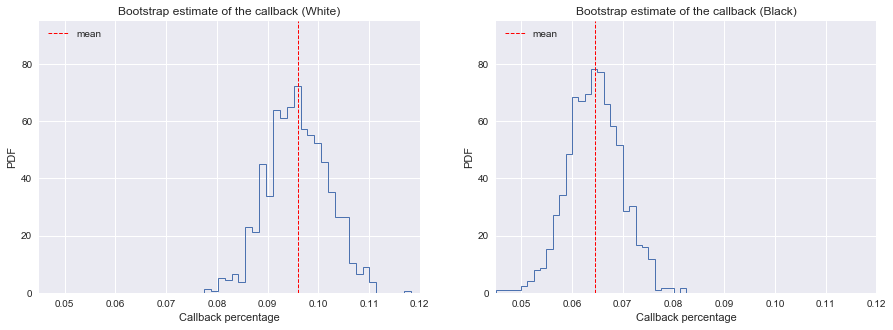

In [9]:
### 
# Plot PDFs for the white and black bootstrap replicates
###
fig, ax = plt.subplots(figsize=(15,5))

w_call_percent_list = [t[0] for t in bs_replicates_percent]
plt.subplot(1, 2, 1)
plot_pdf(w_call_percent_list, w_call_percent_mean, 'Bootstrap estimate of the callback (White)')
    
b_call_percent_list = [t[1] for t in bs_replicates_percent]
plt.subplot(1, 2, 2)
plot_pdf(b_call_percent_list, b_call_percent_mean, 'Bootstrap estimate of the callback (Black)')

plt.show()

In [10]:
# TODO: compute standard error between them
# TODO: compute p-value

### 3.2 Frequentist Statistical Approach

In [11]:
p1 = w_call_sum / w_df.shape[0]
n1 = w_df.shape[0]
p2 = b_call_sum / b_df.shape[0]
n2 = b_df.shape[0]
# print('>>> p1 =', p1, 'n1=', n1)
# print('>>> p2 =', p2, 'n2=', n2)

# sample 1 (White-names) 95% CI
n1_std_err  = np.sqrt((p1 * (1 - p1)) / n1)
p1_95CI_min = p1 - (1.96 * n1_std_err)
p1_95CI_max = p1 + (1.96 * n1_std_err)
print('>>> P1 95% CI              = ', round(p1_95CI_min, 4), '-', round(p1_95CI_max, 4))

# sample 2 (Black-names) 95% CI
n2_std_err  = np.sqrt((p2 * (1 - p2)) / n2)
p2_95CI_min = p2 - (1.96 * n2_std_err)
p2_95CI_max = p2 + (1.96 * n2_std_err)
print('>>> P2 95% CI              = ', round(p2_95CI_min, 4), '-', round(p2_95CI_max, 4))

# pooled sample size (i.e. the overall proportion)
p_hat = (p1 * n1 + p2 * n2) / (n1 + n2)
print('>>> Pooled sample size (p) = ', p_hat)

# standard error
std_err = np.sqrt(p_hat * (1 - p_hat) * ((1/n1) + (1/n2)) )
print('>>> Standard error         = ', std_err)

# test statistic: z-score
z_score = (p1 - p2) / std_err
print('>>> Z-Score                = ', z_score)

import scipy
p_value = 2 * scipy.stats.norm.cdf(-np.abs(z_score))
print('>>> P-Value                = ', p_value)

>>> P1 95% CI              =  0.0848 - 0.1082
>>> P2 95% CI              =  0.0547 - 0.0742
>>> Pooled sample size (p) =  0.0804928131417
>>> Standard error         =  0.00779689403617
>>> Z-Score                =  4.10841215243
>>> P-Value                =  3.98388683759e-05


The [2-sample z-test to compare sample proportion calculator](http://epitools.ausvet.com.au/content.php?page=z-test-2&p1=0.0965&p2=0.0644&n1=2435+&n2=2435+&Conf=0.05&tails=2&samples=2) can be used to validate these results.

In [12]:
# sample 3: difference of the other 2 proportions
p_diff = p1 - p2  # 0.032
print('>>> Difference between the 2 proportions =', p_diff)

# standard error for difference between proportions
std_err_diff = np.sqrt((n1_std_err*n1_std_err) + (n2_std_err*n2_std_err))
print('>>> Standard error for difference        =', std_err_diff)

# compute the confidence interval for 95%
p_diff_95CI_min = p_diff - (1.96 * std_err_diff)
p_diff_95CI_max = p_diff + (1.96 * std_err_diff)
print('>>> P_DIFF 95% CI                        =', round(p_diff_95CI_min, 4), '-', round(p_diff_95CI_max, 4))

>>> Difference between the 2 proportions = 0.0320328542094
>>> Standard error for difference        = 0.00778337058668
>>> P_DIFF 95% CI                        = 0.0168 - 0.0473


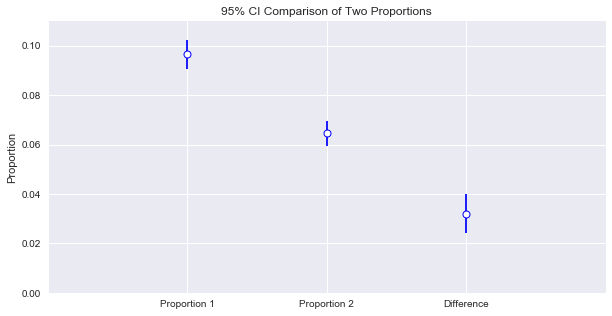

In [13]:
# Plot a 95%CI comparison of the 2 proportions and the difference between them
x = [2, 4, 6]
y = [p1, p2, p_diff]
errors = [n1_std_err, n2_std_err, std_err_diff]

fig, ax = plt.subplots(figsize=(10,5))

plt.errorbar(x, y, yerr=errors, fmt='o', color='b', markerfacecolor='white', markeredgecolor='blue', markeredgewidth=1)
plt.title('95% CI Comparison of Two Proportions')
plt.ylabel('Proportion')
plt.ylim(0.0, 0.11)
plt.xticks((0, 2, 4, 6, 8), ('', 'Proportion 1', 'Proportion 2', 'Difference', ''))
plt.show()

## 4. Write a story describing the statistical significance in the context or the original problem
On this **two-tailed test**, the `p-value` is the probability that the `z-score` is less than **-4.11** or greater than **4.11**. Since the `p-value` (< 0.0001) is smaller than the significance level (0.05), we cannot accept the null hypothesis: the difference between samples is statistically significant and we reject the idea that sample proportions are equal.

In other words, it seems that race could be having an impact on the decision making process of job recruiters to callback.

## 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?
**No**! It simply means that race/name **could be** one of the factors responsible for the difference in callbacks, but there's no guarantee that it is even one of the factors.

It is reasonable to think that other variables in the dataset could be influenting the callback decision from job recruiters. In this exercise, we tested only 1 variable out of 63: many more tests are required before we can conclude that race is the most important factor behind callbacks.